#### Import packages and device selection

In [1]:
import os
import re
import cv2
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional.image import structural_similarity_index_measure
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 160
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

In [5]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

input_L = []
target_ab = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder, desc='Loading color images'):
    img = cv2.imread(os.path.join(path, file), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = cv2.resize(img, (SIZE, SIZE))
    L = img[:, :, 0:1] / 255.0 # (H, W, 1)
    ab = img[:, :, 1:3] / 255.0 # (H, W, 2)
    input_L.append(L)
    target_ab.append(ab)
input_L = np.array(input_L).astype(np.float32) # (N, H, W, 1)
target_ab = np.array(target_ab).astype(np.float32) # (N, H, W, 2)

Loading color images:   0%|          | 0/7129 [00:00<?, ?it/s]

In [6]:
print(input_L.shape, target_ab.shape)

(7129, 160, 160, 1) (7129, 160, 160, 2)
torch.Size([313, 2])


#### Display some samples

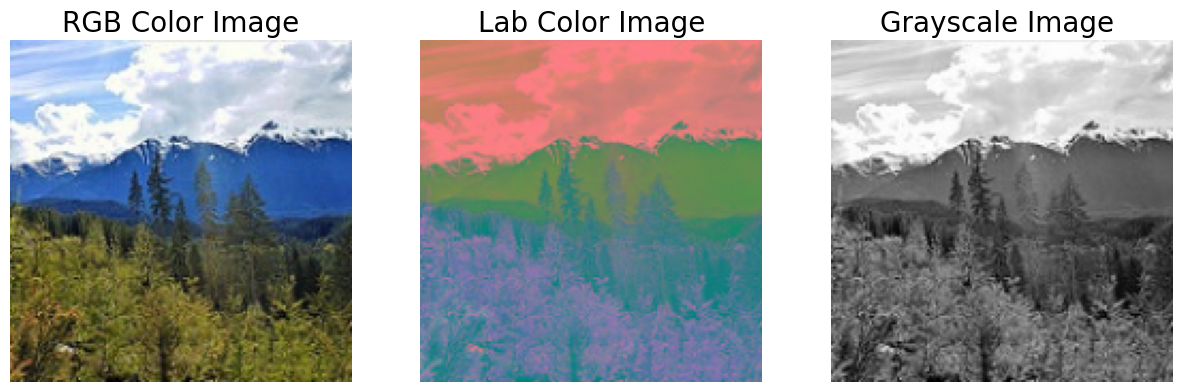

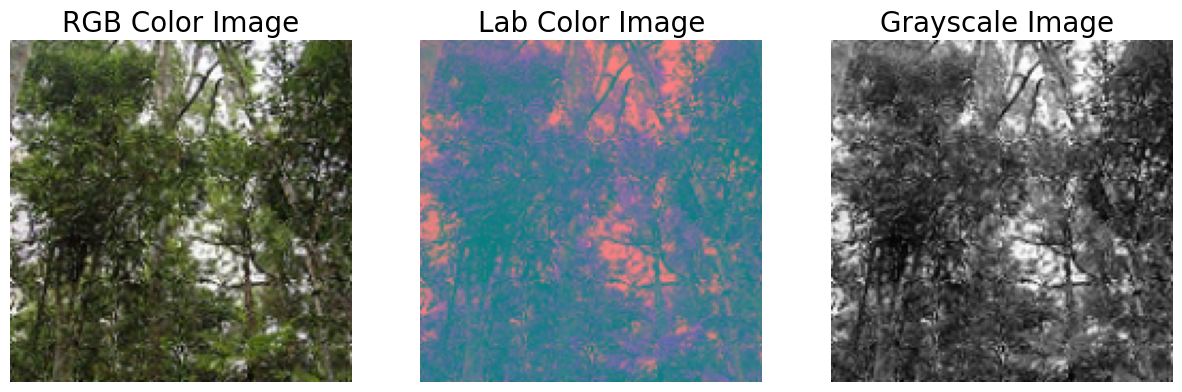

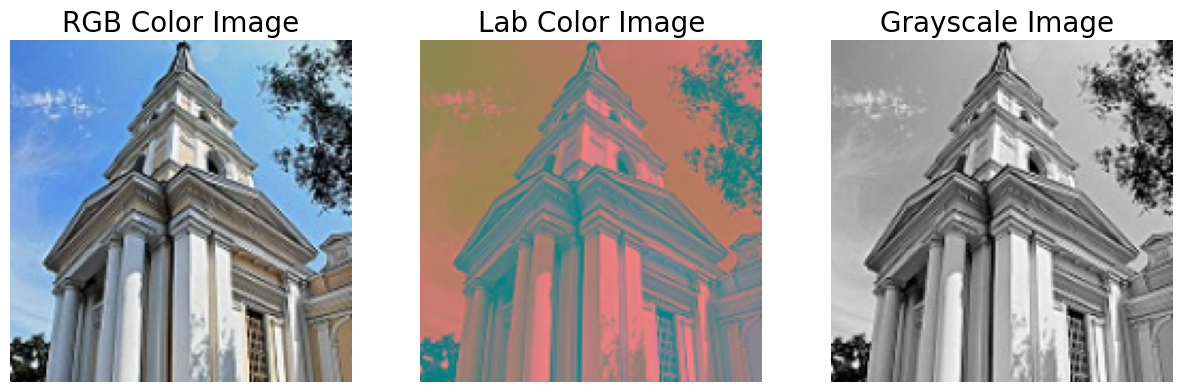

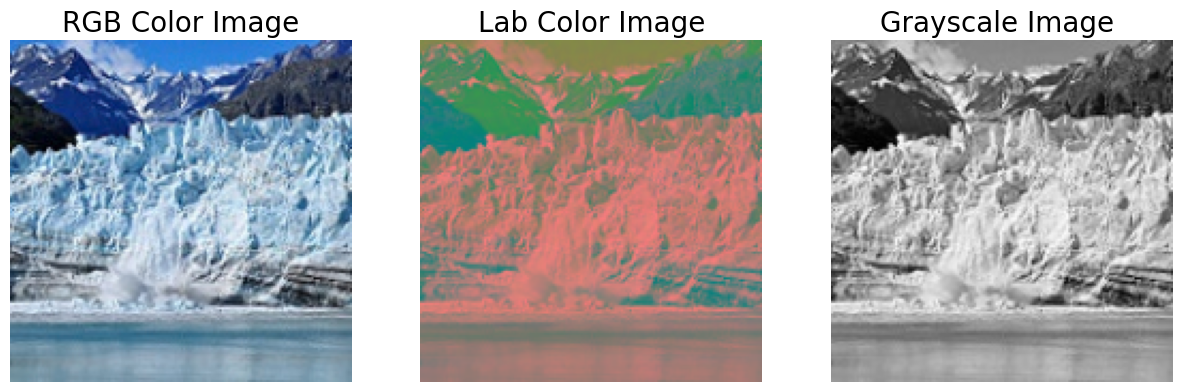

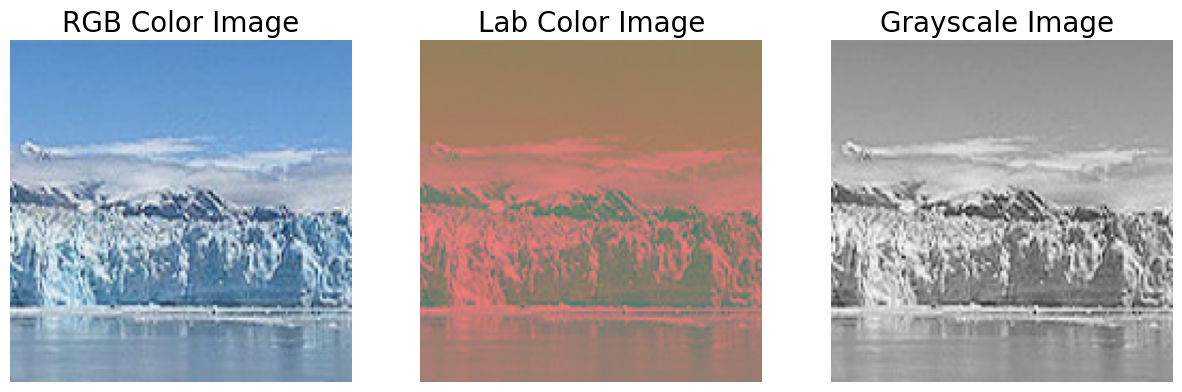

In [7]:
for _ in range(5):
    idx = np.random.randint(0, len(input_L) - 1)
    color_img = np.clip(np.concatenate([input_L[idx], target_ab[idx]], axis=2) * 255, 0, 255).astype(np.uint8) # (H, W, 3)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('RGB Color Image', fontsize=20)
    plt.imshow(np.clip(cv2.cvtColor(color_img, cv2.COLOR_LAB2RGB), 0, 255).astype(np.uint8))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Lab Color Image', fontsize=20)
    plt.imshow(color_img)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow((input_L[idx] * 255).astype(np.uint8).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

#### Split into training and test data

In [8]:
input_L = np.transpose(input_L, (0, 3, 1, 2)) # (N, 1, H, W)
target_ab = np.transpose(target_ab, (0, 3, 1, 2)) # (N, 2, H, W)
L_train, L_test, ab_train, ab_test = train_test_split(input_L, target_ab, train_size=6000, random_state=42)
L_train = torch.tensor(L_train, dtype=torch.float32)
ab_train = torch.tensor(ab_train, dtype=torch.float32)
L_test = torch.tensor(L_test, dtype=torch.float32)
ab_test = torch.tensor(ab_test, dtype=torch.float32)

In [9]:
print(L_train.shape, ab_train.shape)
print(L_test.shape, ab_test.shape)

torch.Size([6000, 1, 160, 160]) torch.Size([6000, 2, 160, 160])
torch.Size([1129, 1, 160, 160]) torch.Size([1129, 2, 160, 160])


In [10]:
L_mean = L_train.mean(dim=(0, 2, 3))
L_std = L_train.std(dim=(0, 2, 3))
ab_mean = ab_train.mean(dim=(0, 2, 3))
ab_std = ab_train.std(dim=(0, 2, 3))

In [11]:
print(L_mean, L_std)
print(ab_mean, ab_std)

tensor([0.4744]) tensor([0.2587])
tensor([0.4964, 0.5035]) tensor([0.0345, 0.0710])


In [12]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, L_data, ab_data, L_transform=None, ab_transform=None):
        self.L_data = L_transform(L_data) if L_transform else L_data
        self.ab_data = ab_transform(ab_data) if ab_transform else ab_data
    def __len__(self):
        return len(self.L_data)

    def __getitem__(self, idx):
        return self.L_data[idx], self.ab_data[idx]

## Training pipeline

In [13]:
trainset = MyDataset(L_train, ab_train, L_transform=transforms.Normalize(mean=L_mean, std=L_std),
                     ab_transform=transforms.Normalize(mean=ab_mean, std=ab_std))
testset = MyDataset(L_test, ab_test, L_transform=transforms.Normalize(mean=L_mean, std=L_std),
                     ab_transform=transforms.Normalize(mean=ab_mean, std=ab_std))
del L_train, L_test, ab_train, ab_test # release memory

In [ ]:
cluster_path = '../data/pts_in_hull.npy'
assert os.path.exists(cluster_path), "Download pts_in_hull.npy and place next to this script"
cluster_centers = torch.from_numpy(np.load(cluster_path)).float() # (313, 2)
cc_l2 = (cluster_centers ** 2).sum(dim=1) # (313,)
lut_coords  = ((torch.stack(torch.meshgrid(torch.arange(256), torch.arange(256)), -1).float()) - 128.0).reshape(-1, 2) # (65536, 2)
d2 = (lut_coords ** 2).sum(dim=1, keepdim=True) + cc_l2.reshape(1, -1) - torch.matmul(2 * lut_coords, cluster_centers.t())
lut = d2.argmin(1) # (65536,)

In [14]:
def compute_ab_prior(dataloader):
    hist = torch.zeros(313, device=device)
    total = 0
    for _, ab in dataloader:
        ab = ab.to(device)
        ab = ab * 255.0 - 128.0
        B, _, H, W = ab.shape
        ab = ab.permute(0, 2, 3, 1).reshape(-1, 2)
        ab_l2 = (ab ** 2).sum(dim=1, keepdim=True)  # (B*H*W, 1)
        cross = torch.matmul(ab, cluster_centers.t())  # (B*H*W, 313)
        d2 = ab_l2 + cc_l2 - 2 * cross  # (B*H*W, 313)
        labels = d2.argmin(dim=1)
        hist += torch.bincount(labels, minlength=313).to(device)  # accumulate histogram
        total += labels.numel()
    return hist / total # p(c)

def make_rebalancing_weights(priors, alpha=0.5):
    C = priors.size(0)
    uniform = torch.full_like(priors, 1.0 / C, device=device)
    smoothed = (1.0 - alpha) * uniform + alpha * priors
    weights = 1.0 / smoothed
    return weights / weights.mean()

def image_gradients(tensors):
    dh = tensors[:, :, :, 1:] - tensors[:, :, :, :-1]  # horizontal gradient
    dv = tensors[:, :, 1:, :] - tensors[:, :, :-1, :]  # vertical gradient
    return dh, dv

def unstandardize(tensor, mean, std):
    unnorm = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
    return unnorm(tensor).clamp(0, 1)

def lab_to_rgb(x):
    lab = x.permute(1, 2, 0).cpu().numpy()
    L = (lab[:, :, 0] * 255).astype(np.uint8)
    a = (lab[:, :, 1] * 255).astype(np.uint8)
    b = (lab[:, :, 2] * 255).astype(np.uint8)
    lab_cv = np.stack([L, a, b], axis=2)
    rgb = cv2.cvtColor(lab_cv, cv2.COLOR_LAB2RGB)
    return rgb

#### Early stopping used to stop training if model begins to overfit

In [15]:
def save_checkpoint(model, name='checkpoint'):
    torch.save(model.state_dict(), f"../models/{name}.pth")

class EarlyStopping:
    def __init__(self, patience=10, delta=5e-6):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, net):
        if self.best_score > val_loss:
            self.best_score = val_loss
            self.counter = 0
            save_checkpoint(net)
        elif self.best_score + self.delta < val_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#### Rebalancing Weights Loss class

In [16]:
class RebalanceLoss(nn.Module):
    def __init__(self, weight_lut, coeff=0.5):
        super(RebalanceLoss, self).__init__()
        self.register_buffer('weight_lut', weight_lut)
        self.register_buffer('mean', ab_mean.reshape(1, 2, 1, 1))
        self.register_buffer('std', ab_std.reshape(1, 2, 1, 1))
        self.coeff = coeff
        self.l2 = nn.MSELoss(reduction='none')  # L2 loss for ab channels

    def forward(self, inputs, targets):
        B, C, H, W = inputs.shape
        targets = (targets * self.std + self.mean) * 255.0 - 128.0 # unnormalize to [-128, 127]
        a = (targets[:, 0, :, :].long() + 128.0)
        b = (targets[:, 1, :, :].long() + 128.0)
        idx = a * 256 + b  # (B, H, W)
        weight = self.weight_lut[idx].reshape(B, 1, H, W)  # (B*H*W) -> (B, H, W) -> (B, 1, H, W)
        mse_map = self.l2(inputs, targets)
        weighted_mse = (mse_map * weight).sum()
        dh_i, dv_i = image_gradients(inputs) # (B, C, H, W-1), (B, C, H-1, W)
        dh_t, dv_t = image_gradients(targets) # (B, C, H, W-1), (B, C, H-1, W)
        weighted_h = weight[..., :, :-1]
        weighted_v = weight[..., :-1, :]
        grad_h = ((dh_i - dh_t) ** 2 * weighted_h.expand_as(dh_i)).sum()
        grad_v = ((dv_i - dv_t) ** 2 * weighted_v.expand_as(dv_i)).sum()
        weighted_grad = grad_h + grad_v
        return (self.coeff * weighted_mse + (1 - self.coeff) * weighted_grad) / float(B * C * H * W)

RuntimeError: Type '<class '__main__.RebalanceLoss'>' cannot be compiled since it inherits from nn.Module, pass an instance instead

In [17]:
def compute_pcc(pred, targets):
    pred_flat = pred.reshape(pred.size(0), -1)
    target_flat = targets.reshape(targets.size(0), -1)
    vx = pred_flat - pred_flat.mean(dim=1, keepdim=True)
    vy = target_flat - target_flat.mean(dim=1, keepdim=True)
    numerator = (vx * vy).sum(dim=1) # covariance
    denominator = torch.sqrt((vx**2).sum(dim=1) * (vy**2).sum(dim=1)) # standard deviation
    return (numerator / denominator).mean()

def fit(net, trainloader, optimizer, loss_fn):
    net.train()
    total_loss, total_rmse, total_psnr, total_ssim, total_pcc, count = 0, 0, 0, 0, 0, 0
    for L, ab in trainloader:
        L, ab = L.to(device), ab.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = net(L)
            loss = loss_fn(out, ab)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        count += len(ab)
        with torch.no_grad():
            batch_rmse = torch.sqrt(nn.MSELoss()(out, ab))
            batch_psnr = (20 * torch.log10(1.0 / batch_rmse))
            total_rmse += batch_rmse.item() * len(ab)
            total_psnr += batch_psnr.item() * len(ab)
            total_ssim += structural_similarity_index_measure(out, ab).item() * len(ab)
            total_pcc += compute_pcc(out, ab).item() * len(ab)
        del out, L, ab, loss
    return total_loss / count, total_rmse / count, total_psnr / count, total_ssim / count, total_pcc / count

def predict(net, testloader, loss_fn):
    net.eval()
    total_loss, total_rmse, total_psnr, total_ssim, total_pcc, count = 0, 0, 0, 0, 0, 0
    ins, preds, truths = [], [], []
    with torch.no_grad():
        for L, ab in testloader:
            L, ab = L.to(device), ab.to(device)
            with torch.cuda.amp.autocast():
                out = net(L)
                ins.append(L.cpu())
                preds.append(out.cpu())
                truths.append(ab.cpu())
            total_loss += loss_fn(out, ab).item()
            count += len(ab)
            batch_rmse = torch.sqrt(nn.MSELoss()(out, ab))
            batch_psnr = (20 * torch.log10(1.0 / batch_rmse))
            total_rmse += batch_rmse.item() * len(ab)
            total_psnr += batch_psnr.item() * len(ab)
            total_ssim += structural_similarity_index_measure(out, ab).item() * len(ab)
            total_pcc += compute_pcc(out, ab).item() * len(ab)
            del out, L, ab
    return ins, preds, truths, total_loss / count, total_rmse / count, total_psnr / count, total_ssim / count, total_pcc / count

#### Objective method for k fold cross validation

In [18]:
def objective(trial, trainset, X):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64,256, 512, 1024])
    coeff = trial.suggest_float('coeff', 0.0, 1.0, log=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses, mean_loss = [], 0
    train_loss, train_rmse, train_psnr, train_ssim, train_pcc = 0, 0, 0, 0, 0
    val_loss, val_rmse, val_psnr, val_ssim, val_pcc = 0, 0, 0, 0, 0
    split_n = 0
    prog_bar = tqdm(kf.split(X), desc="Splits", position=0)
    for train_idx, val_idx in prog_bar:
        split_n += 1
        trainloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        valloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        prior = compute_ab_prior(trainloader)
        weights = make_rebalancing_weights(prior, alpha=0.5)
        weight_lut = weights[lut].to(device)  # (65536,)
        criterion = RebalanceLoss(weight_lut, coeff=coeff)
        del train_idx, val_idx, prior, weights, weight_lut
        net = Net().to(device)
        optimizer = optim.Adam(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=2)
        for epoch in range(50):
            train_loss, train_rmse, train_psnr, train_ssim, train_pcc = fit(net, trainloader, optimizer, criterion)
            ins, preds, truths, val_loss, val_rmse, val_psnr, val_ssim, val_pcc = predict(net, valloader, criterion)
            del ins, preds, truths
            scheduler.step(val_ssim)
            prog_bar.set_description(
                f"Split {split_n} - Epoch {epoch + 1} |\nlr={lr:.3e}, batch size={batch_size:.3e}, coeff={coeff:.3e} |\n"
                f"Metrics train/val: RMSE={train_rmse:.3e}/{val_rmse:.3e}, "
                f"PSNR={train_psnr:.3e}/{val_psnr:.3e}, SSIM={train_ssim:.3e}/{val_ssim:.3e}, "
                f"PCC={train_pcc:.3e}/{val_pcc:.3e} | Loss: {train_loss:.3e}/{val_loss:.3e}")
            torch.cuda.empty_cache()
        del net, optimizer, scheduler
        val_losses.append(val_loss)
        mean_loss = np.mean(val_losses)
        trial.report(mean_loss, split_n)
        torch.cuda.empty_cache()
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_loss

#### CAE NN definition

out = (in - kernel + 2 * pad) / stride + 1

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)  # input is L only
        self.conv2 = nn.Conv2d(128, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)

        self.convt1 = nn.ConvTranspose2d(512, 512, 4, 2, 1)
        self.convt2 = nn.ConvTranspose2d(1024, 256, 4, 2, 1)
        self.convt3 = nn.ConvTranspose2d(512, 128, 4, 2, 1)
        self.convt4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.convt5 = nn.ConvTranspose2d(256, 2, 4, 2, 1)  # output is ab (2 channels)

        self.bnorm1 = nn.BatchNorm2d(256)
        self.bnorm2 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.2)
        self.lrelu = nn.LeakyReLU()
        self.final = nn.Conv2d(3, 2, 1, 1)  # concat u5 + x = (2+1)=3 → 2 (ab)

    def forward(self, x): # x is (B, 1, H, W) => L channel
        d1 = self.lrelu(self.conv1(x)) # (B, 128, 80, 80)
        d2 = self.lrelu(self.conv2(d1)) # (B, 128, 40, 40)
        d3 = self.lrelu(self.bnorm1(self.conv3(d2))) # (B, 256, 20, 20)
        d4 = self.lrelu(self.bnorm2(self.conv4(d3))) # (B, 512, 10, 10)
        d5 = self.lrelu(self.bnorm2(self.conv5(d4))) # (B, 512, 5, 5)
        u1 = self.lrelu(self.convt1(d5)) # (B, 512, 10, 10)
        u1 = torch.cat([u1, d4], dim=1) # (B, 1024, 10, 10)
        u2 = self.lrelu(self.convt2(u1)) # (B, 256, 20, 20)
        u2 = torch.cat([u2, d3], dim=1) # (B, 512, 20, 20)
        u3 = self.lrelu(self.convt3(u2)) # (B, 128, 40, 40)
        u3 = torch.cat([u3, d2], dim=1) # (B, 256, 40, 40)
        u4 = self.lrelu(self.convt4(u3)) # (B, 128, 80, 80)
        u4 = torch.cat([u4, d1], dim=1) # (B, 256, 80, 80)
        u5 = self.lrelu(self.convt5(u4)) # (B, 2, 160, 160) — ab prediction
        u5 = torch.cat([u5, x], dim=1) # (B, 3, 160, 160)
        x = self.final(self.dropout(u5)) # (B, 2, 160, 160)
        return x # predicted ab

In [20]:
writer = SummaryWriter('../runs')
net = Net().to(device)
writer.add_graph(net, torch.zeros(1, 1, SIZE, SIZE).to(device))
writer.flush()
summary(net, input_size=(1, 1, SIZE, SIZE), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 2, 160, 160]          --
├─Conv2d: 1-1                            [1, 128, 80, 80]          2,176
├─LeakyReLU: 1-2                         [1, 128, 80, 80]          --
├─Conv2d: 1-3                            [1, 128, 40, 40]          262,272
├─LeakyReLU: 1-4                         [1, 128, 40, 40]          --
├─Conv2d: 1-5                            [1, 256, 20, 20]          524,544
├─BatchNorm2d: 1-6                       [1, 256, 20, 20]          512
├─LeakyReLU: 1-7                         [1, 256, 20, 20]          --
├─Conv2d: 1-8                            [1, 512, 10, 10]          2,097,664
├─BatchNorm2d: 1-9                       [1, 512, 10, 10]          1,024
├─LeakyReLU: 1-10                        [1, 512, 10, 10]          --
├─Conv2d: 1-11                           [1, 512, 5, 5]            4,194,816
├─BatchNorm2d: 1-12                      [1, 512, 5, 5

Run command:\
tensorboard --logdir=runs\
Visible at http://localhost:6006/

#### Hyper parameter tuning

In [ ]:
X = np.zeros(len(trainset))
torch.cuda.empty_cache()
scaler = torch.cuda.amp.GradScaler()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(lambda trial: objective(trial, trainset, X), n_trials=5)

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#### Entire dataset

In [32]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=5)
prior = compute_ab_prior(trainloader)
weights = make_rebalancing_weights(prior, alpha=0.5)
weight_lut = weights[lut].to(device) # (65536,)
criterion = RebalanceLoss(weight_lut, coeff=0.5)
del cluster_centers, cc_l2, lut_coords, d2, lut, prior, weights, weight_lut
early_stopping = EarlyStopping()
train_RMSEs, train_PSNRs, train_SSIMs, train_PCCs, train_losses = [], [], [], [], []
test_RMSEs, test_PSNRs, test_SSIMs, test_PCCs, test_losses = [], [], [], [], []
last_checkpoint = None

In [ ]:
def update_plot():
    line1.set_data(range(len(train_losses)), train_losses)
    line2.set_data(range(len(test_losses)), test_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()

In [33]:
prog_bar = tqdm(range(50), total=50, desc='Training', position=0)

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='Train Loss')
line2, = ax.plot([], [], label='Test Loss')
ax.legend()

torch.cuda.empty_cache()
scaler = torch.cuda.amp.GradScaler()
for epoch in prog_bar:
    train_loss, train_RMSE, train_PSNR, train_SSIM, train_PCC = fit(net, trainloader, optimizer, criterion)
    train_losses.append(train_loss)
    train_RMSEs.append(train_RMSE)
    train_PSNRs.append(train_PSNR)
    train_SSIMs.append(train_SSIM)
    train_PCCs.append(train_PCC)
    ins, preds, truths, test_loss, test_RMSE, test_PSNR, test_SSIM, test_PCC = predict(net, testloader, criterion)
    del ins, preds, truths
    test_losses.append(test_loss)
    test_RMSEs.append(test_RMSE)
    test_PSNRs.append(test_PSNR)
    test_SSIMs.append(test_SSIM)
    test_PCCs.append(test_PCC)
    scheduler.step(test_SSIM)
    early_stopping(test_loss, net)
    current_lr = optimizer.param_groups[0]['lr']
    prog_bar.set_description(f"Epoch {epoch + 1} | lr={current_lr:.3e} |\n"
                             f"Metrics train/test: RMSE={train_RMSE:.3e}/{test_RMSE:.3e}, "
                             f"PSNR={train_PSNR:.3e}/{test_PSNR:.3e}, SSIM={train_SSIM:.3e}/{test_SSIM:.3e}, "
                             f"PCC={train_PCC:.3e}/{test_PCC:.3e} | Loss: {train_loss:.3e}/{test_loss:.3e}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    update_plot()
    torch.cuda.empty_cache()
    if early_stopping.early_stop:
        print("Early stopping")
        break
save_checkpoint(net, 'lastcheck')
writer.flush()

Training:   0%|          | 0/50 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
class ModelWithLoss(nn.Module):
    def __init__(self, net, loss_fn):
        super().__init__()
        self.net = net
        self.loss_fn = loss_fn

    def forward(self, x, y):
        preds = self.net(x)
        return self.loss_fn(preds, y)

## Evaluate results

To use NN:
rt = torch.jit.load("model_and_loss.pt")\
rt.eval()\
out = rt(input_tensor, target_tensor)

In [ ]:
net.load_state_dict(torch.load('../models/checkpoint.pth'))
ins, preds, truths, test_loss, test_RMSE, test_PSNR, test_SSIM, test_PCC = predict(net, testloader, criterion)
net_script = ModelWithLoss(net, RebalanceLoss(weight_lut, coeff=0.5))
del weight_lut
net_script = torch.jit.script(net_script)
net_script.save("model_and_loss.pt")
net.load_state_dict(torch.load('../models/lastcheck.pth'))
ins2, preds2, truths2, loss2, rmse2, psnr2, ssim2, pcc2 = predict(net, testloader, criterion)

In [ ]:
ins = torch.cat(ins, dim=0)
preds = torch.cat(preds, dim=0)
truths = torch.cat(truths, dim=0)
ins = [unstandardize(x, L_mean, L_std)for x in ins]
preds = [unstandardize(x, ab_mean, ab_std)for x in preds]
truths = [unstandardize(x, ab_mean, ab_std) for x in truths]
preds_rgb = []
truths_rgb = []
for L, ab_pred, ab_true in zip(ins, preds, truths):
    lab_pred = torch.cat([L, ab_pred], dim=0)  # [3, H, W]
    lab_true = torch.cat([L, ab_true], dim=0)
    preds_rgb.append(lab_to_rgb(lab_pred))
    truths_rgb.append(lab_to_rgb(lab_true))
preds = preds_rgb
truths = truths_rgb
ins2 = torch.cat(ins2, dim=0)
preds2 = torch.cat(preds2, dim=0)
truths2 = torch.cat(truths2, dim=0)
ins2 = [unstandardize(x, L_mean, L_std)for x in ins2]
preds2 = [unstandardize(x, ab_mean, ab_std)for x in preds2]
truths2 = [unstandardize(x, ab_mean, ab_std) for x in truths2]
preds_rgb = []
truths_rgb = []
for L, ab_pred, ab_true in zip(ins2, preds2, truths2):
    lab_pred = torch.cat([L, ab_pred], dim=0)
    lab_true = torch.cat([L, ab_true], dim=0)
    preds_rgb.append(lab_to_rgb(lab_pred))
    truths_rgb.append(lab_to_rgb(lab_true))
preds2 = preds_rgb
truths2 = truths_rgb

In [ ]:
print(test_loss, test_RMSE, test_PSNR, test_SSIM, test_PCC)
print(loss2, rmse2, psnr2, ssim2, pcc2)

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(train_RMSEs, label='Train RMSE')
plt.plot(test_RMSEs, label='Test RMSE')
plt.axhline(y=test_RMSE, color='g', linestyle='--')
plt.axhline(y=rmse2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_PSNRs, label='Train PSNR')
plt.plot(test_PSNRs, label='Test PSNR')
plt.axhline(y=test_PSNR, color='g', linestyle='--')
plt.axhline(y=psnr2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_SSIMs, label='Train SSIM')
plt.plot(test_SSIMs, label='Test SSIM')
plt.axhline(y=test_SSIM, color='g', linestyle='--')
plt.axhline(y=ssim2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure()
plt.plot(train_PCCs, label='Train PCC')
plt.plot(test_PCCs, label='Test PCC')
plt.axhline(y=test_PCC, color='g', linestyle='--')
plt.axhline(y=pcc2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.axhline(y=test_loss, color='g', linestyle='--')
plt.axhline(y=loss2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [ ]:
for _ in range(5):
    idx = np.random.randint(0, len(ins))
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Last check Image', fontsize=20)
    plt.imshow(preds2[idx] , cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Best check Image', fontsize=20)
    plt.imshow(preds[idx])  # Already a [H, W, 3] NumPy RGB image
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Groundtruth Image', fontsize=20)
    plt.imshow(truths[idx])  # Already a [H, W, 3] NumPy RGB image
    plt.axis('off')
    plt.show()